### 1. Загрузка данных и подготовка к анализу

In [1]:
# Библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [5]:
data.columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contr_period', 'group_visits', 'age',
       'other_serv', 'mth_end_contr', 'lifetime',
       'visits_wk', 'visits_wk_cur_mth',
       'churn']

#### Выводы

Дан датасет, состоящий из 14 столбцов и 4000 строк. Пропуски отсутствуют, тип данных каждого столбца соответствует содержимому. Для удобства названия столбцов приведены к строчным буквам и переименованы.

### 2. Исследовательский анализ данных (EDA)

#### 2.1. Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [6]:
display(data.describe())

,gender,near_location,partner,promo_friends,phone,contr_period,group_visits,age,other_serv,mth_end_contr,lifetime,visits_wk,visits_wk_cur_mth,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


#### Выводы

Пропущенных значений не наблюдается,  средние значения говорят о том, что:
- среди пользователей по половому признаку большинство с бинарным значением '1'(предположительно мужчины)
- в большинстве случаев люди живут или работают близко от фитнес центра
- меньше половины клиентов пришли по партнерской программе
- примерно треть воспользовалась промокодом для друзей
- большинство клиентов оставило свой номер телефона
- среднестатистическая длительность текущего абонемента примерно 4,7 месяца
- примерно половина пользователей посещает групповые занятия
- средний возраст клиентов 29 лет
- средняя выручка от других услуг фитнес-центра 146,9
- средний срок до окончания текущего абонемента 4,3 месяца
- среднее время с момента первого обращения в фитнес-центр 3,7 месяца
- средняя частота посещений в неделю около 1,9
- средняя частота посещений в неделю за предыдущий месяц 1,8
- средний отток окло 27%

#### 2.2. Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 

In [7]:
print('Cредние значения признаков оттока')
display(data[data['churn'] == 1].mean())
print()
print('Cредние значения признаков действующих клиентов')
display(data[data['churn'] == 0].mean())

Cредние значения признаков оттока


gender                 0.510839
near_location          0.768143
partner                0.355325
promo_friends          0.183789
phone                  0.902922
contr_period           1.728558
group_visits           0.268615
age                   26.989632
other_serv           115.082899
mth_end_contr          1.662582
lifetime               0.990575
visits_wk              1.474995
visits_wk_cur_mth      1.044546
churn                  1.000000
dtype: float64


Cредние значения признаков действующих клиентов


gender                 0.510037
near_location          0.873086
partner                0.534195
promo_friends          0.353522
phone                  0.903709
contr_period           5.747193
group_visits           0.464103
age                   29.976523
other_serv           158.445715
mth_end_contr          5.283089
lifetime               4.711807
visits_wk              2.024876
visits_wk_cur_mth      2.027882
churn                  0.000000
dtype: float64

#### Выводы

Сравнение двух групп показывает:
- в отток попадает 35% клиентов по партнерским программам и  18% пришедших по промокодам друзей
- длительность текущего действующего абонемента ушедшего клиента в среднем 1,7 месяц
- 27% ушедших ходили на групповые занятия, 46% действующих клиентов посещают групповые занятия 
- ушедшие клиенты тратили окло 115р на дополнительные сервисы, действующие клиенты тратят около 158р
- срок до окончания текущего действующего абонемента у оттока в среднем 1,7
- время с момента первого обращения в фитнес-центр в группе оттока примерно 1 месяц
- среднее количество посещений в группе оттока 1,5р в неделю, а за последний месяц 1р
- среднее количество посещений в группе действующих клиентов 2р в неделю

Подведем итоги. Группу оттога характеризуют посещения фитнес центра 1-1,5р в неделю, редкие посещения групповых занятий, клиент уходит примерно через 1 - 1,7 месяца от начала посещений центра.

#### 2.3. Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [8]:
churn_group_cat = ['gender', 'partner', 'near_location', 'promo_friends', 'group_visits']
churn_group_ind = ['contr_period', 'age','lifetime', 
                   'mth_end_contr','other_serv',
                   'visits_wk','visits_wk_cur_mth']

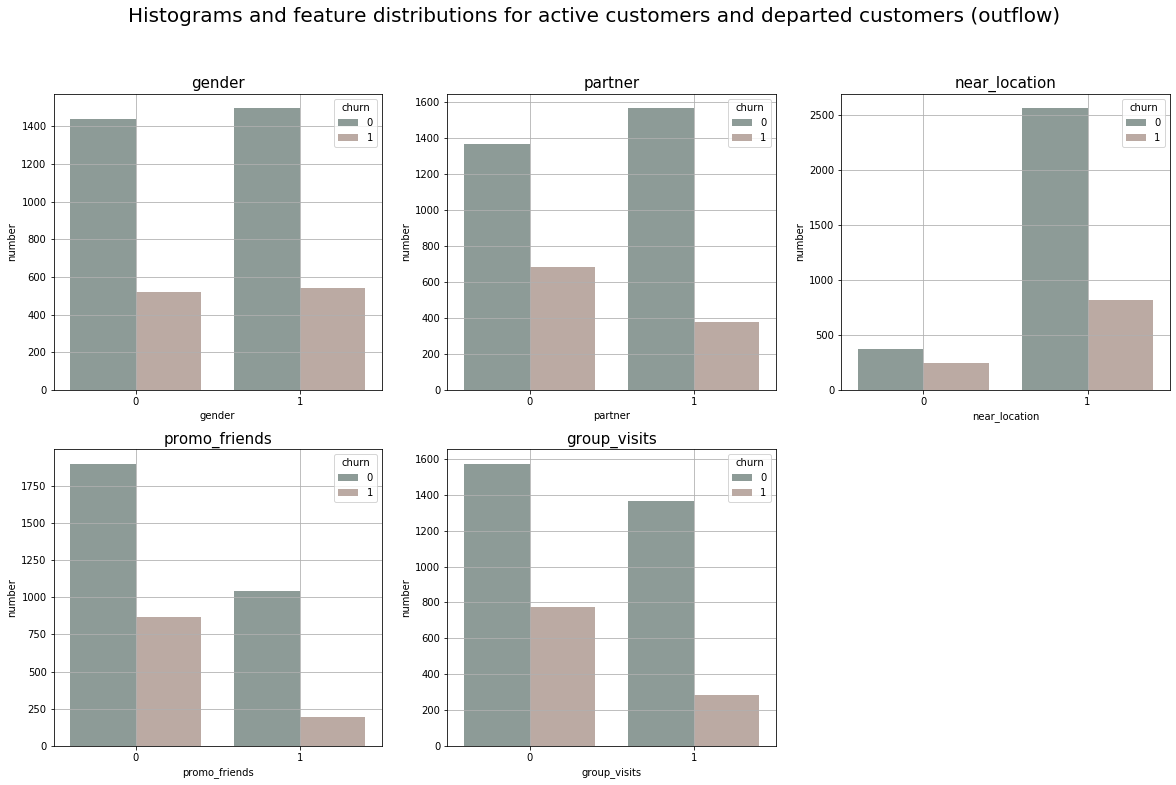

In [9]:
# гистограммы для бинарных данных
fig = plt.figure(figsize=(20,12))
for k in range(1, (len(churn_group_cat)+1)): 
    fig.add_subplot(2, 3, k)
    hist_group = data.groupby(['churn', churn_group_cat[k-1]]).agg({churn_group_cat[k-1]: 'count'})
    hist_group.columns = ['number']
    hist_group = hist_group.reset_index()
    sns.barplot(x = churn_group_cat[k-1], y = 'number' , hue='churn', data = hist_group, palette='Set2', saturation=0.15)
    plt.grid(True)
    plt.ylabel('number')
    plt.title(churn_group_cat[k-1], fontsize=15)
fig.suptitle('Histograms and feature distributions for active customers and departed customers (outflow)', fontsize=20)
plt.show
None

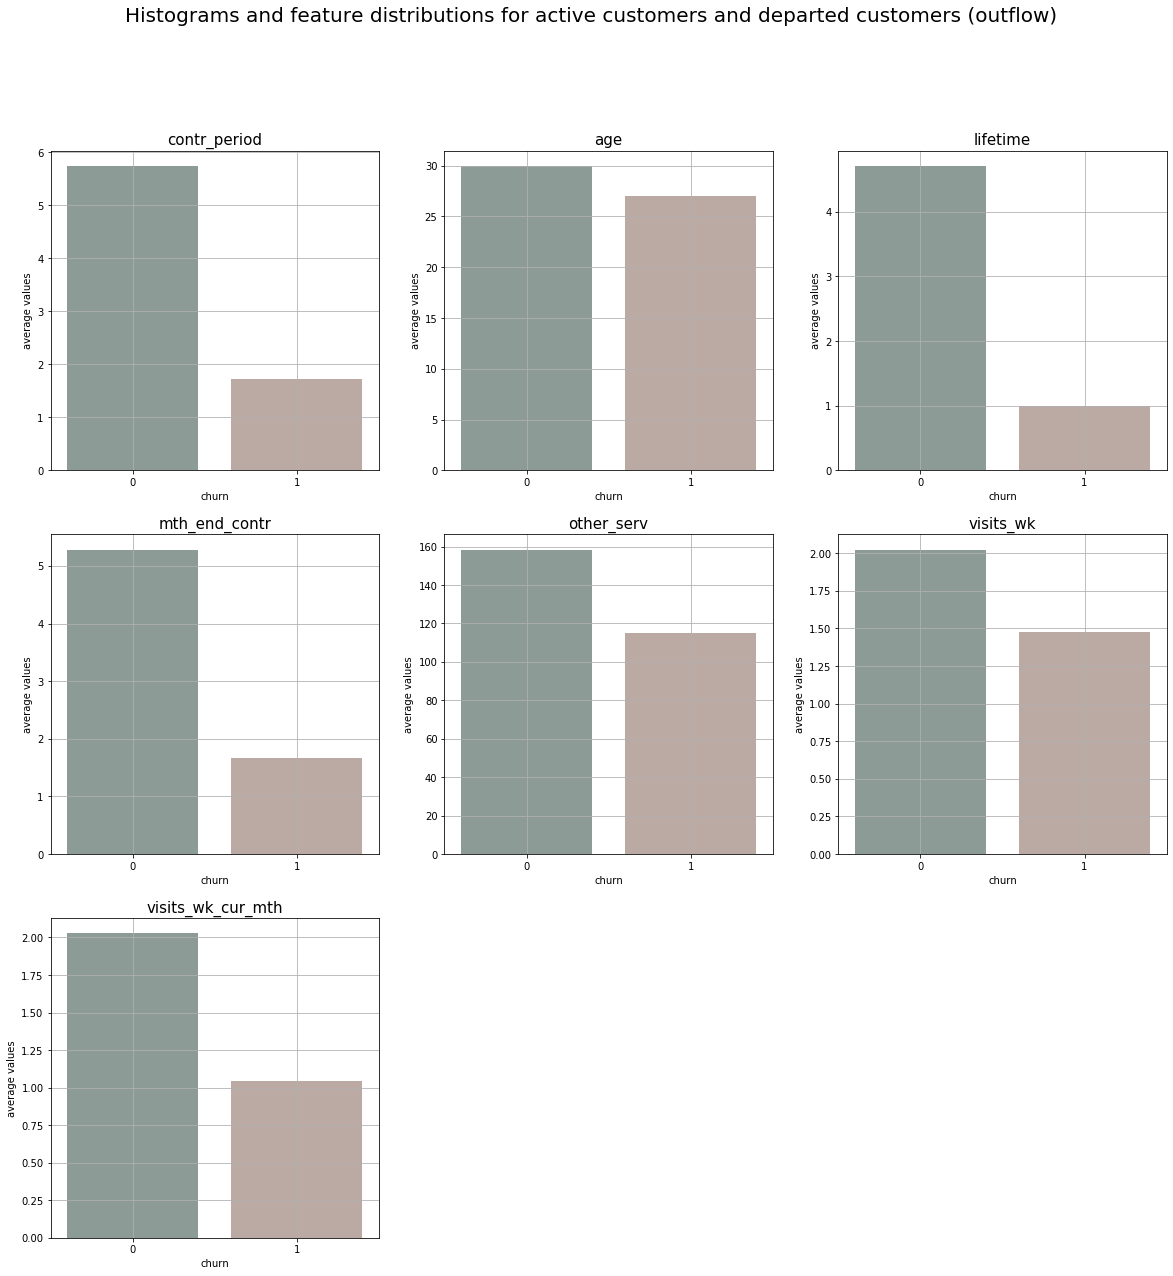

In [10]:
# гистограммы для количественных данных
fig = plt.figure(figsize=(20,20))

for k in range(1, (len(churn_group_ind)+1)): 
    fig.add_subplot(3, 3, k)
    hist_group = data.groupby(['churn']).agg({churn_group_ind[k-1]: 'mean'})
    hist_group.columns = ['average values']
    hist_group = hist_group.reset_index()
    sns.barplot(x = 'churn', y = 'average values', data = hist_group, palette='Set2', saturation=0.15)
    plt.grid(True)
    plt.ylabel('average values')
    plt.title(churn_group_ind[k-1], fontsize=15)
fig.suptitle('Histograms and feature distributions for active customers and departed customers (outflow)', fontsize=20)
plt.show
None

#### 2.4. Построим матрицу корреляций

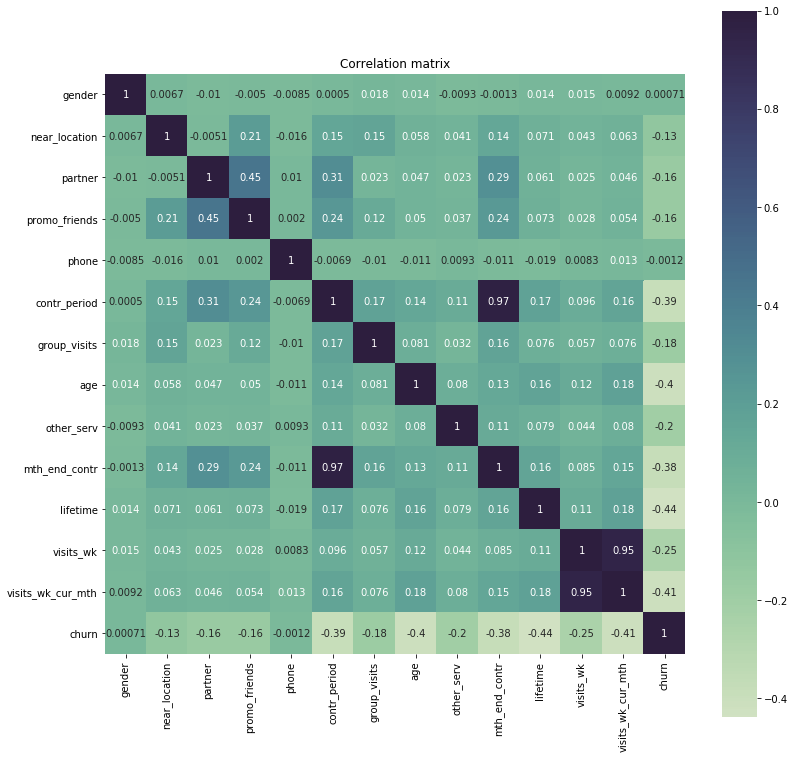

In [11]:
cm = data.corr()
plt.figure(figsize=(13,13))
plt.title('Correlation matrix')
cmap=sns.cubehelix_palette(start=0.5, rot=-0.7, as_cmap=True)
sns.heatmap(cm, annot = True, square=True, cmap=cmap)

#### Выводы

Матрица кореляции показывает зависимости между показателями. Первыми бросаются в глаза данные `visits_wk_cur_mth` и `visits_wk`, `contr_period` и `mth_end_contr`. Первая пара показателей дают высокую зависимость, потому что по сути это одно и то же измерение, но в разных временных отрезках.  Вторая пара показателей скорее всего показывает, что примерно на середине контракта происходит переломный момент. Также можно уследить взаимосвязь у показвателей по программам лояльности `promo_friends` и `partner`

### 3. Построим модель прогнозирования оттока клиентов

In [12]:
# Разбивка данных на обучающую и валидационную выборку
X = data.drop('churn', axis=1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [14]:
# Обучение модели логистической регрессией
logistic_model = LogisticRegression(solver='liblinear',random_state = 0)
logistic_model.fit(X_train, y_train)
y_predict_log = logistic_model.predict(X_test)
print(y_predict_log)

[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0
 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 1 0 0 0 1 0 0 0 1 0 

In [15]:
# Обучение модели случайным лесом
forest_model = RandomForestClassifier(n_estimators=100, random_state = 0)
forest_model.fit(X_train, y_train)
y_predict_for = forest_model.predict(X_test)
print(y_predict_for)

[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0
 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 1 0 0 0 1 0 0 0 1 0 

In [16]:
def metric_rating(y_pred):
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    recall = sklearn.metrics.recall_score(y_test, y_pred)
    print('Показатель Accuracy', acc)
    print('Показатель Precision',precision)
    print('Показатель Recall',recall)
    
print('Оценка метрик логистической регрессии')
metric_rating(y_predict_log)
print()
print('Оценка метрик случайного леса')
metric_rating(y_predict_for)

Оценка метрик логистической регрессии
Показатель Accuracy 0.925
Показатель Precision 0.8711340206185567
Показатель Recall 0.8284313725490197

Оценка метрик случайного леса
Показатель Accuracy 0.91125
Показатель Precision 0.841025641025641
Показатель Recall 0.803921568627451


#### Выводы

Разница между моделями небольшая. Лучше оказаласть модель логистической реграессии ее показатели Accuracy и  Recall больше.

### 4. Kластеризация клиентов

#### 4.1. Стандартизируйте данные.

In [17]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#### 4.2. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

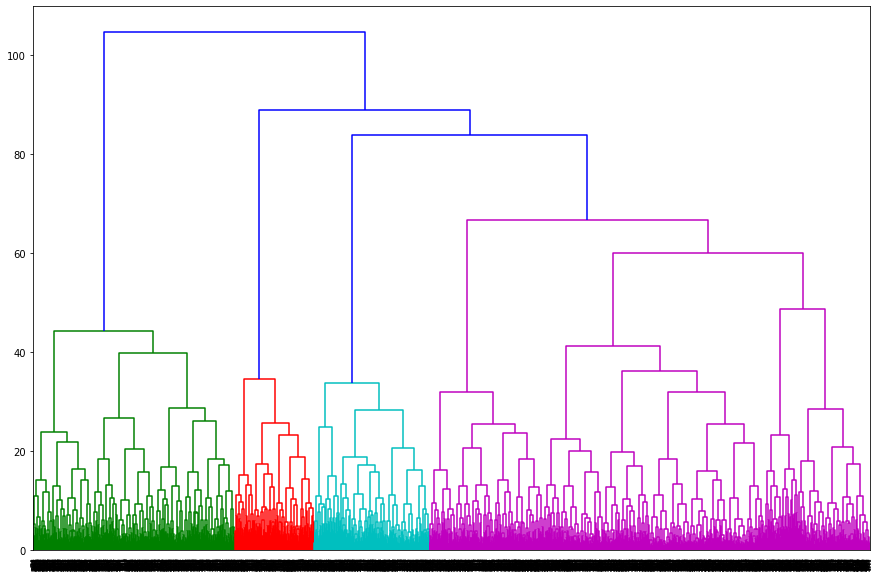

In [18]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

#### Выводы

Визуально можно предположить 6 кластеров

#### 4.3. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [19]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_sc)

#### 4.4. Посмотрим на средние значения признаков для кластеров

In [20]:
data['cluster_km'] = labels # сохраняем метки в поле основного датасета
cluster_mean = round(data.groupby('cluster_km').mean(), 4).reset_index()
display(cluster_mean)

,cluster_km,gender,near_location,partner,promo_friends,phone,contr_period,group_visits,age,other_serv,mth_end_contr,lifetime,visits_wk,visits_wk_cur_mth,churn
0,0,0.5268,1.0000,0.0558,0.0359,1.0,1.9587,0.4006,29.0420,145.2040,1.8716,3.4472,1.9375,1.8020,0.3379
1,1,0.5105,0.9570,0.7562,0.5165,1.0,11.0380,0.5445,30.0270,165.3157,10.0430,4.8501,2.1869,2.1807,0.0180
2,2,0.5233,0.8627,0.4715,0.3057,0.0,4.7772,0.4275,29.2979,144.2082,4.4663,3.9404,1.8542,1.7240,0.2668
3,3,0.5010,0.0000,0.4627,0.0765,1.0,2.3920,0.2199,28.5736,136.7906,2.2467,2.9025,1.7310,1.5564,0.4283
4,4,0.4821,1.0000,0.8862,0.6547,1.0,2.5818,0.3836,28.6957,134.4772,2.4182,3.1918,1.4983,1.3413,0.3504


#### Выводы

У первого кластера(в таблице `0`) достаточно маленький отток 0,0786, небольшой процент по программе `promo_friends`, большой стаж по `lifetime`, 44% клиентов посещает групповые занятия и в зал приходят в среднем 2,8р в неделю.

#### 4.5. Построим распределение признаков для кластеров

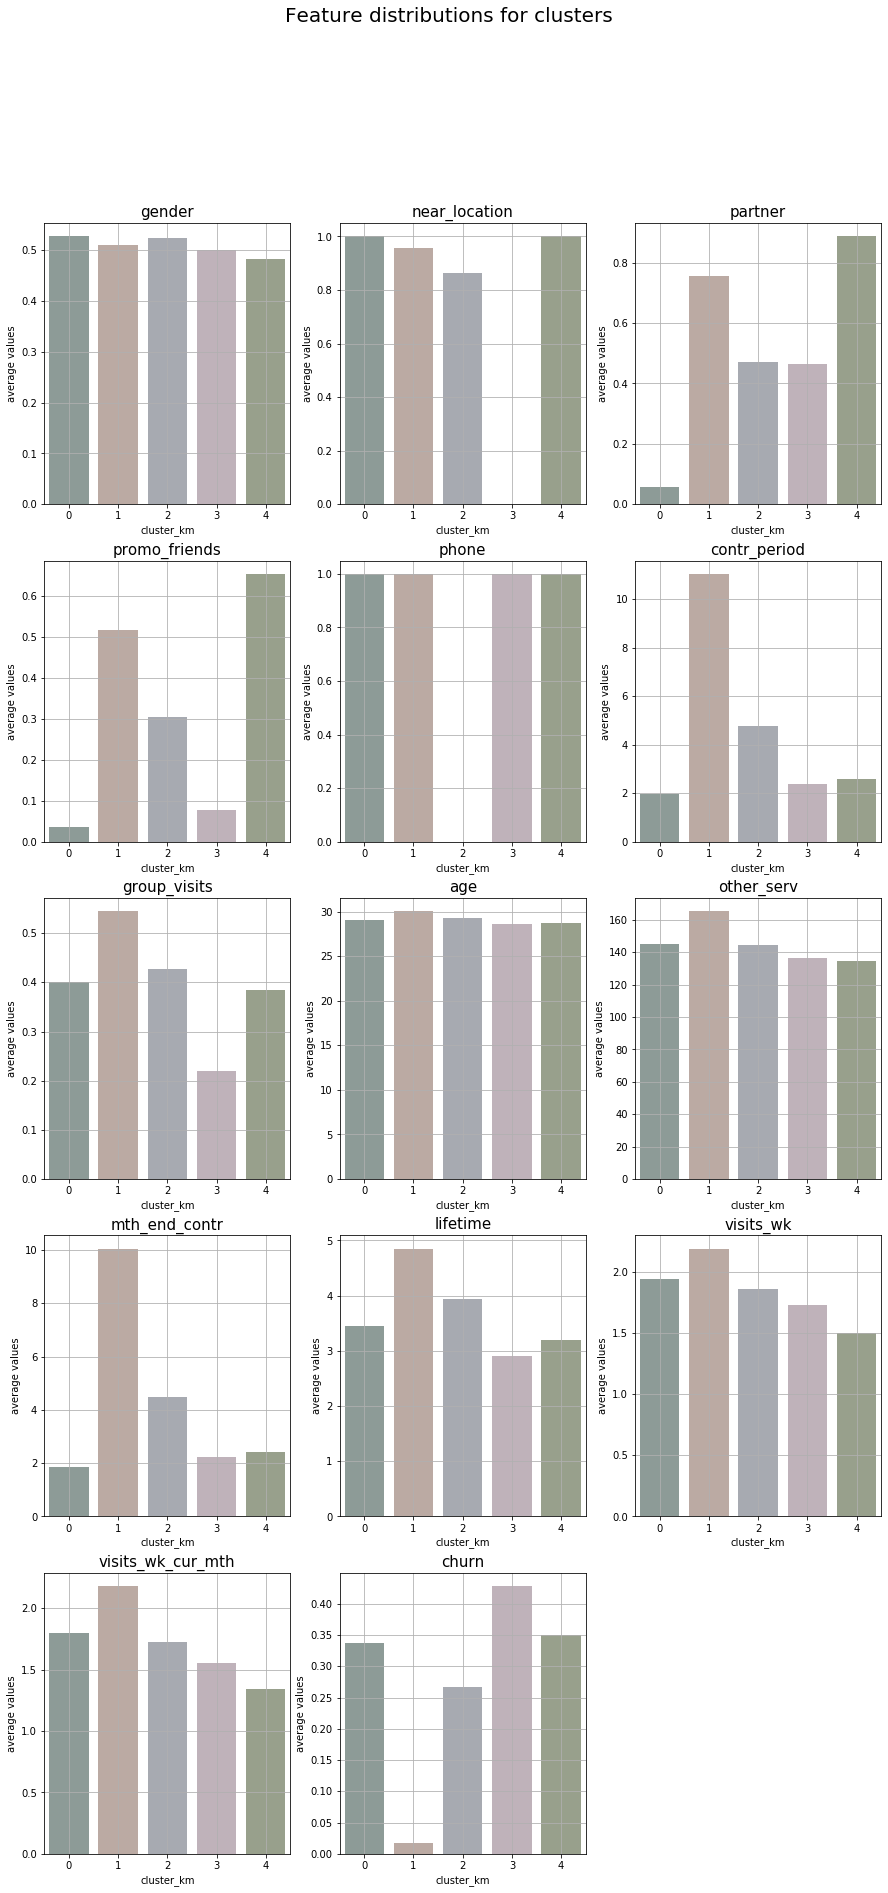

In [21]:
features = list(cluster_mean.drop(['cluster_km'], axis=1))

fig = plt.figure(figsize=(15,30))

for k in range(1, (len(features)+1)): 
    fig.add_subplot(5, 3, k)
    sns.barplot(x = 'cluster_km', y = features[k-1], data = cluster_mean, palette='Set2', saturation=0.15)
    plt.grid(True)
    plt.ylabel('average values')
    plt.xlabel('cluster_km')
    plt.title(features[k-1], fontsize=15)
fig.suptitle('Feature distributions for clusters', fontsize=20)
plt.show
None

#### Выводы

Самый большой отток у второго кластера (в таблице `1`). Меньше всего клиентов из этого кластера пришло по программе `promo_friends`, меньше всего посещений групповых занятий, меньше `contr_period`.

#### 4.6. Для каждого полученного кластера посчитаем долю оттока (методом groupby()). 

In [22]:
print('Доли оттока кластеров')
display(cluster_mean['churn'])

Доли оттока кластеров


0    0.3379
1    0.0180
2    0.2668
3    0.4283
4    0.3504
Name: churn, dtype: float64

#### Выводы

Кластеры отличаются по доле оттока. Самый большой отток у второго кластера(в таблице `1`), самый маленький у четвертого(в таблице `3`).

### Выводы

В ходе работы мы выявили 5 целевых групп по кластерам. Они отличаются по количеству оттоков клиентов и привычкам: посещение групповых занятий, частота посещения зала, привычка пользоваться дополнительными сервисами или нет, пользуются программами лояльности и нет.
При выяснилось, что большая часть клиентов уходят в отток спустя 1-1,7 месяц после первого обращения и приобретения абонемента. Возможно стоит именно в этот период уделять больше внимания клиентам. Например проводить различные акции  для повышения лояльности и вовлечения клиентов, а также напоминания и опросы типа 'фитбэк'.